# imports

In [1]:
%matplotlib notebook
from __future__ import division
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from IPython.display import IFrame

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip, imap
import itertools
import random
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap, compose_fmap, Average
from schlichtanders import myfunctools
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point
from schlichtanders.mymeta import proxify
from schlichtanders.mycontextmanagers import ignored

In [4]:
import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm

import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [5]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
tm.inputting_references.update(['to_be_randomized'])
tm.inputting_references, tm.outputting_references

({'extra_inputs',
  'flat',
  'inputs',
  'n_data',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'loglikelihood', 'norm_det', 'norm_dets', 'outputs'})

In [8]:
from schlichtanders.myobjects import NestedNamespace

# Simple Posterior

For testing we choose a conjugate likelihood/prior combination such that the resulting posterior form is known in advance.

It seems the only combination with commonly known results is Gauss, considering that we need a distribution which can be expressed as a function of some standard random source, because of stochastic backpropagation.

As the final goal is to have more complex distributions than Gaussians, another distribution might

In [10]:
prior_u = 0
prior_s2 = 0.5

likelihood_s2 = 2

sample = np.random.normal(size=100, scale=4, loc=5)

posterior_s2 = 1 / (1/prior_s2 + len(sample)/likelihood_s2)
posterior_u = (prior_u/prior_s2 + sample.sum()/likelihood_s2) * posterior_s2

In [11]:
target_params = posterior_u, posterior_s2
target_params

(5.037619753098677, 0.019230769230769232)

In [12]:
likelihood = tm.Merge(pm.Gauss(init_var=likelihood_s2),
                      ignore_references={'parameters_positive'})
likelihood

Merge2 { 'inputs': [], 'outputs': Gauss.outputs, 'parameters': [Gauss.mean]}

In [13]:
q = pm.Gauss()
q

Gauss2 { 'inputs': [],
  'outputs': Gauss2.outputs,
  'parameters': [Gauss2.mean],
  'parameters_positive': [Gauss2.var]}

In [14]:
prior = tm.fix_params(pm.Gauss(init_mean=prior_u, init_var=prior_s2))
prior

Gauss3_fixed { 'inputs': [], 'outputs': Gauss3.outputs}

In [15]:
model = tm.variational_bayes(likelihood, 'parameters', q, priors=prior)
model

variational_lower_bound { 'inputs': [],
  'kl_prior': variational_lower_bound.kl_prior,
  'logposterior': variational_lower_bound.logposterior,
  'logprior': variational_lower_bound.logprior,
  'n_data': variational_lower_bound.n_data,
  'outputs': Gauss.outputs,
  'parameters': [Gauss2.mean],
  'parameters_positive': [Gauss2.var]}

In [16]:
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))
flat

"Gauss2.var_squareplus_centered:Gauss2.mean_centered"

In [17]:
tm.d3viz(([flat] + model.logP['inputs'], model.logP['outputs']), 'tmp/model.html')
IFrame('tmp/model.html', width=700, height=500)

In [91]:
tm.reduce_all_identities()

In [92]:
loss = tm.loss_variational(model)
optimizer_kwargs = tm.numericalize(
    loss, flat,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=0.01),
)
climin_args = izip(imap(lambda x:(x,), itertools.repeat(sample)), itertools.repeat({}))

In [93]:
opt = optimizer(
    identifier="adadelta",
#     steprate=1e-6,
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

batch_precompile
batch_precompile


In [94]:
best_loss = optimizer_kwargs['num_loss'](opt.wrt, sample)
best_params = None
last_best_i = opt.n_iter

<IPython.core.display.Javascript object>


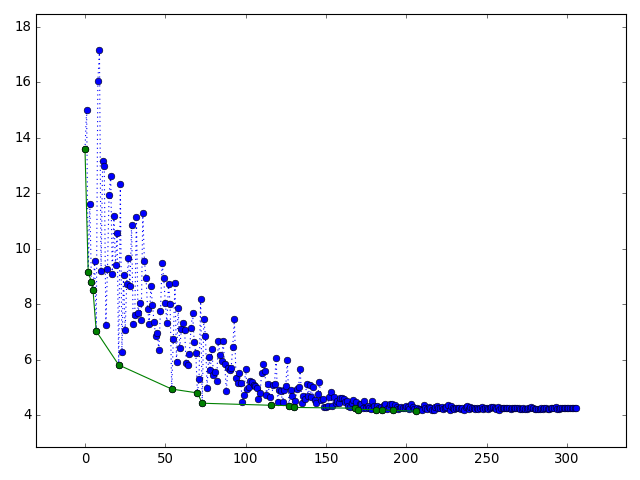

In [95]:
plt.figure()
h = plt.plot(last_best_i, best_loss, 'b:o')[0]
h_best = plt.plot(last_best_i, best_loss, 'g-o')[0]

In [96]:
for info in opt:
    loss = optimizer_kwargs['num_loss'](opt.wrt, sample)
    if opt.n_iter - last_best_i > 100:
        break
    if loss < best_loss:
        last_best_i = opt.n_iter
        best_loss = loss
        best_params = opt.wrt
        add_point(h_best, opt.n_iter, best_loss)
    add_point(h, opt.n_iter, loss)

In [97]:
best_loss

4.1466622925131382

In [98]:
params = q['parameters'] + q['parameters_positive']
f_q_param = theano.function([flat], params)

In [99]:
for s, n, t in zip(map(str, params), f_q_param(best_params), target_params):
    print "%40s : %10g ~ %g" % (s, n, t)

                    Gauss5.mean_centered :    5.09596 ~ 5.10609
                      Gauss5.var_reparam :  0.0127354 ~ 0.0192308


We fortunately get roughly the parameters of the posterior. The variance seems overestimated, always, but still fine. Kind of a factor of two.

# Complex Posterior Normflows

In [18]:
x = tm.as_tensor_variable([0.5]) #T.vector()
y = x + 0.3 * T.sin(2*np.pi*(x - 0.5))
func = tm.Model(inputs=[x], outputs=y, name="sin")

In [22]:
import sympy as sm

In [24]:
z = sm.symbols("z")

In [39]:
sm.nsolve(sm.Eq(z + 0.3 * sm.sin(2*sm.pi*(z - 0.5)), 0), z, 6)

mpf('0.29039085257651727')

In [19]:
f = func.function()

<IPython.core.display.Javascript object>


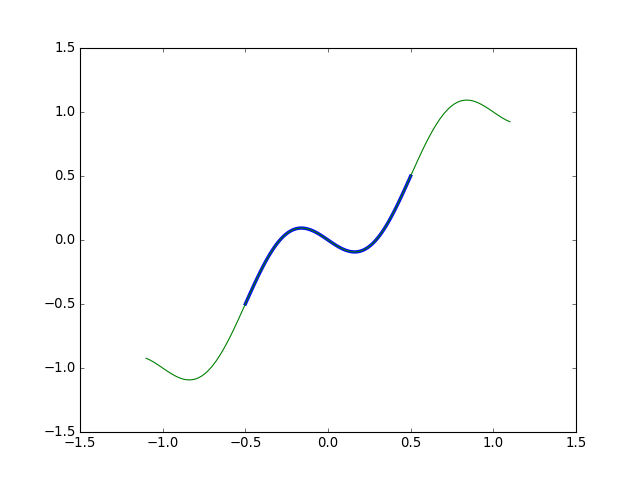

In [20]:
plt.figure()
num_x = np.linspace(-0.5, 0.5, 100)
# num_x = np.linspace(0, 1, 100)
plt.plot(num_x, [f([_num_x]) for _num_x in num_x], linewidth=3)
num_x = np.linspace(-1.1, 1.1, 100)
# num_x = np.linspace(-0.6, 1.6, 100)
plt.plot(num_x, [f([_num_x]) for _num_x in num_x])


In [21]:
likelihood = tm.Merge(pm.GaussianNoise(y, init_var=0.01), func, ignore_references={'parameters', 'parameters_positive'})
likelihood

Merge6 { 'inputs': [TensorConstant{(1,) of 0.5}], 'outputs': GaussianNoise.outputs}

In [138]:
sampler = likelihood.function()
data = np.array([sampler([0.5]) for n in range(5000)])

<IPython.core.display.Javascript object>


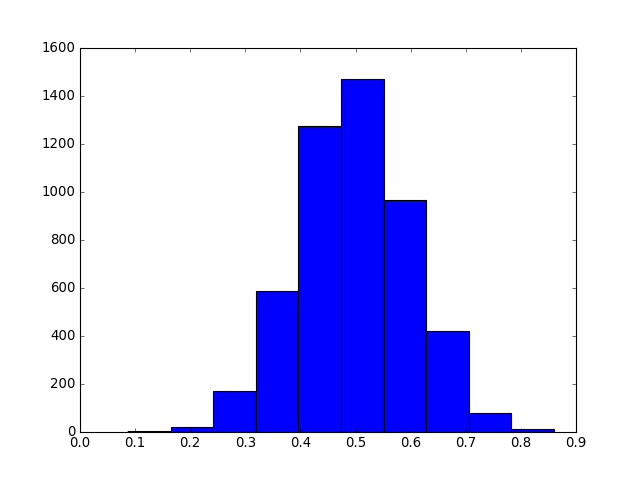

(array([    2.,    20.,   170.,   586.,  1276.,  1472.,   965.,   420.,
           78.,    11.]),
 array([ 0.087491  ,  0.16470645,  0.24192189,  0.31913734,  0.39635278,
         0.47356823,  0.55078368,  0.62799912,  0.70521457,  0.78243002,
         0.85964546]),
 <a list of 10 Patch objects>)

In [139]:
plt.figure()
plt.hist(data)

---

In [140]:
prior = tm.fix_params(pm.DiagGauss(1, init_var=[1]))
# base_posterior = tm.fix_params(pm.DiagGauss(1))
base_posterior = pm.DiagGauss(1)
posterior = base_posterior
# transform_posteriors = [dm.PlanarTransform() for _ in range(4)] + [dm.LocScaleTransform()]
transform_posteriors = [dm.RadialTransform() for _ in range(4)]
for tr in transform_posteriors:
    posterior = tm.normalizing_flow(tr, posterior)
model = tm.variational_bayes(likelihood, 'inputs', posterior, priors=prior)

In [141]:
loss = tm.loss_variational(model)
tm.reduce_all_identities()

parameters = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

In [142]:
model

variational_lower_bound7 { 'inputs': [],
  'kl_prior': variational_lower_bound7.kl_prior,
  'logposterior': variational_lower_bound7.logposterior,
  'logprior': variational_lower_bound7.logprior,
  'n_data': variational_lower_bound7.n_data,
  'norm_det': RadialTransform16.norm_det,
  'outputs': GaussianNoise8.outputs,
  'parameters': [ RadialTransform16.z0_centered,
                  RadialTransform15.z0_centered,
                  RadialTransform14.z0_centered,
                  RadialTransform13.z0_centered,
                  DiagGauss12.mean_centered],
  'parameters_positive': [ RadialTransform16.alpha_reparam,
                           RadialTransform16.beta+alpha_reparam,
                           RadialTransform15.alpha_reparam,
                           RadialTransform15.beta+alpha_reparam,
                           RadialTransform14.alpha_reparam,
                           RadialTransform14.beta+alpha_reparam,
                           RadialTransform13.alpha_reparam,
   

In [143]:
batch_size = 10
n_batches = len(data) // batch_size
def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)

optimizer_kwargs = tm.numericalize(loss, flat,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(
        weights_regularizer=itertools.cycle(weights_regularizer_1epoch())
    ),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=3),
)

# climin_args = izip(imap(lambda x:(x,), itertools.repeat(data)), itertools.repeat({}))
climin_args = izip(imap(lambda x:(x,), chunk(batch_size, itertools.cycle(data))), itertools.repeat({}))

opt = optimizer(
    identifier="adadelta",
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

batch_precompile
batch_precompile


In [144]:
best_loss = optimizer_kwargs['num_loss'](opt.wrt, data)
best_params = None
last_best_i = opt.n_iter // n_batches

<IPython.core.display.Javascript object>


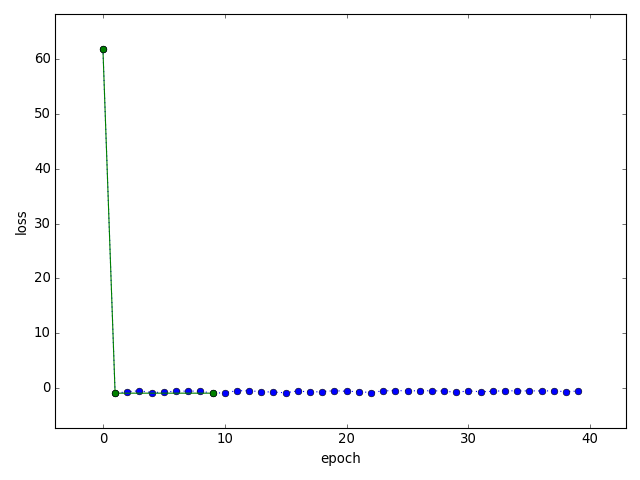

In [145]:
plt.figure()
# plt.yscale('log')
h = plt.plot(last_best_i, best_loss, 'b:o')[0]
h_best = plt.plot(last_best_i, best_loss, 'g-o')[0]
plt.ylabel("loss")
plt.xlabel("epoch")

In [146]:
with ignored(KeyboardInterrupt):
    for info in every(n_batches, opt):
        current_epoch = opt.n_iter // n_batches
        _loss = optimizer_kwargs['num_loss'](opt.wrt, data)
        if current_epoch - last_best_i > 30:
            break
        if _loss < best_loss:
            last_best_i = current_epoch
            best_loss = _loss
            best_params = opt.wrt
            add_point(h_best, current_epoch, best_loss)
        add_point(h, current_epoch, _loss)

In [147]:
best_loss

-0.872419108027915

In [148]:
posterior_sampler = theano.function([flat], posterior['outputs'])

<IPython.core.display.Javascript object>


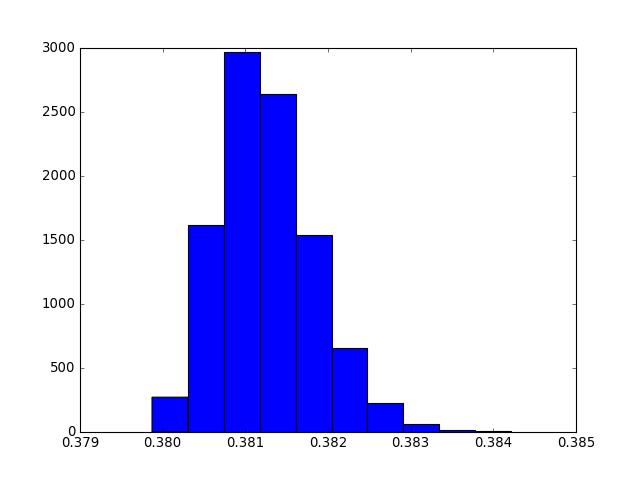

In [149]:
plt.figure()
plt.hist(np.array([posterior_sampler(best_params) for _ in range(10000)]))
pass

This seems as if it cannot find the two/three modes of the underlying posterior 

# Complex Posterior Mixture

In [42]:
x = tm.as_tensor_variable([0.5]) #T.vector()
y = x + 0.3 * T.sin(2*np.pi*x)
func = tm.Model(inputs=[x], outputs=y, name="sin")

In [43]:
likelihood = tm.Merge(pm.GaussianNoise(y, init_var=0.001), func, ignore_references={'parameters', 'parameters_positive'})
likelihood

Merge10 { 'inputs': [TensorConstant{(1,) of 0.5}], 'outputs': GaussianNoise2.outputs}

In [44]:
sampler = likelihood.function()
data = np.array([sampler([0.5]) for n in range(5000)])

---

In [45]:
prior = tm.fix_params(pm.DiagGauss(1, init_var=[1]))
base_posteriors = [pm.DiagGauss(1) for _ in range(3)]
posterior =pm.Mixture(*base_posteriors)
model = tm.variational_bayes(likelihood, 'inputs', posterior, priors=prior)

In [46]:
loss = tm.loss_variational(model)
tm.reduce_all_identities()

In [47]:
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
parameters += tm.prox_reparameterize(model['parameters_psumto1'], tm.softmax, tm.softmax_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

In [48]:
flat

"DiagGauss4.var_squareplus_centered:DiagGauss5.var_squareplus_centered:DiagGauss6.var_squareplus_centered:Mixture.mixture_probs_softmax_centered:DiagGauss4.mean_centered:DiagGauss5.mean_centered:DiagGauss6.mean_centered"

In [49]:
tm.d3viz(loss, "tmp/loss.html")
IFrame("tmp/loss.html", width=700, height=700)

In [50]:
batch_size = 10
n_batches = len(data) // batch_size
def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)

optimizer_kwargs = tm.numericalize(loss, flat,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(
        weights_regularizer=itertools.cycle(weights_regularizer_1epoch())
    ),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=1),
)

# climin_args = izip(imap(lambda x:(x,), itertools.repeat(data)), itertools.repeat({}))
climin_args = izip(imap(lambda x:(x,), chunk(batch_size, itertools.cycle(data))), itertools.repeat({}))

opt = optimizer(
    identifier="adadelta",
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

batch_precompile
batch_precompile


In [51]:
best_loss = optimizer_kwargs['num_loss'](opt.wrt, data)
best_params = None
last_best_i = opt.n_iter // n_batches

<IPython.core.display.Javascript object>


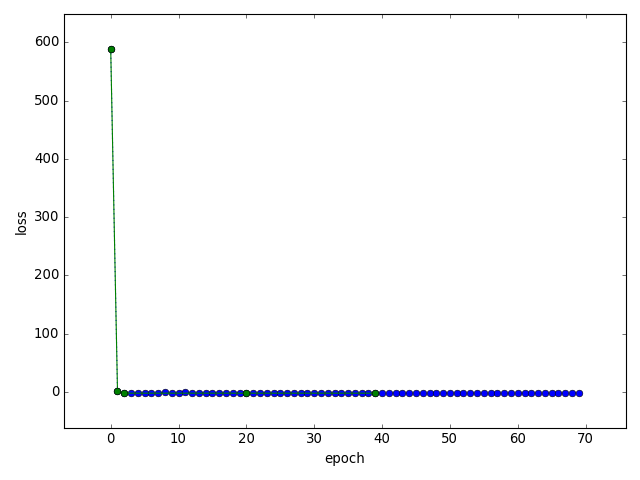

In [52]:
plt.figure()
# plt.yscale('log')
h = plt.plot(last_best_i, best_loss, 'b:o')[0]
h_best = plt.plot(last_best_i, best_loss, 'g-o')[0]
plt.xlabel("epoch")
plt.ylabel("loss")

In [53]:
with ignored(KeyboardInterrupt):
    for info in every(n_batches, opt):
        current_epoch = opt.n_iter // n_batches
        _loss = optimizer_kwargs['num_loss'](opt.wrt, data)
        if current_epoch - last_best_i > 30:
            break
        if _loss < best_loss:
            last_best_i = current_epoch
            best_loss = _loss
            best_params = opt.wrt
            add_point(h_best, current_epoch, best_loss)
        add_point(h, current_epoch, _loss)

In [54]:
best_loss

-2.0343992364993406

In [55]:
posterior_sampler = theano.function([flat], posterior['outputs'])

<IPython.core.display.Javascript object>


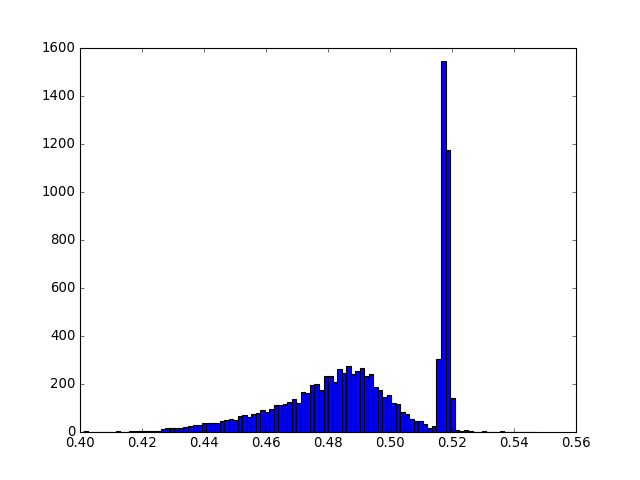

In [56]:
plt.figure()
plt.hist(np.array([posterior_sampler(best_params) for _ in range(10000)]), bins=100)
pass

In [57]:
f_mixture_probs = theano.function([flat], posterior.mixture_probs)
f_mixture_probs(best_params)

array([ 0.34532004,  0.34060609,  0.31407387])

TODO test more noise on initial parameters

TODO check why normflows gives that low log-likelihoods (seems like a bad minima)

# Two Parameters Complex Posterior Mixture

In [13]:
x = tm.as_tensor_variable([0.0, 0.0]) #T.vector()
# x = tm.as_tensor_variable([0.5, 0.5]) #T.vector()
y = 0.3 * T.sin(2*np.pi*(x[0] - 0.5)) + x[0] + x[1] #+ np.exp(-x[1]**2)
# y = 0.3 * T.sin(2*np.pi*(x[0])) + x[0] + x[1] #+ np.exp(-x[1]**2)
func = tm.Model(inputs=[x], outputs=y, name="sin")
f = func.function()

In [14]:
@np.vectorize
def myfunc(a,b):
    return f([a,b])

<IPython.core.display.Javascript object>


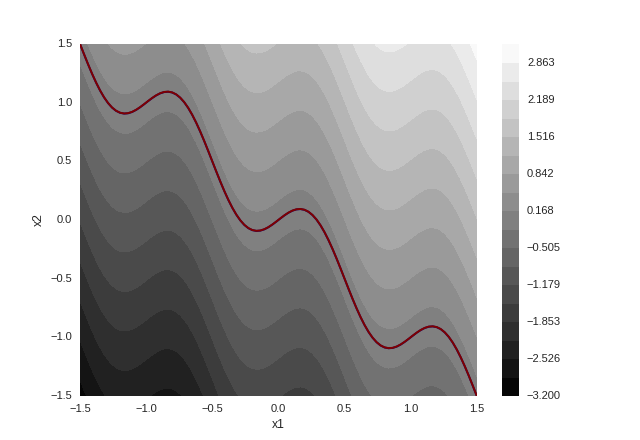

In [89]:
plt.figure()
# num_x = np.linspace(-0, 1, 100)
num_x = np.linspace(-1.5, 1.5, 100)
# num_x = np.linspace(-0.6, 1.6, 100)
# num_x = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(num_x, num_x)

levels = np.linspace(-3.2, 3.2, 20)
# levels = np.linspace(-1.2, 3.6, 20)
h = plt.contourf(X1, X2, myfunc(X1, X2), cmap=plt.cm.gray, levels=levels)
# l=f([0.5, 0.5])
l=f([0.0, 0.0])
h2 = plt.contour(X1, X2, myfunc(X1, X2), cmap=plt.cm.jet, levels=[l, l+0.001])
plt.xlabel("x1")
plt.ylabel("x2")

plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(h)

In [66]:
xs = []
ys = []
for _ in xrange(100):
    l = np.random.normal(loc=f([0.0, 0.0]), scale=0.07)
    h2 = plt.contour(X1, X2, myfunc(X1, X2), cmap=plt.cm.jet, levels=[l, l+0.001])
    p = h2.collections[1].get_paths()[0]
    v = p.vertices
    xs += v[:,0].tolist()
    ys += v[:,1].tolist()

In [67]:
xs_ = np.array(xs)
ys_ = np.array(ys)

In [69]:
xs_.size

23291

<IPython.core.display.Javascript object>


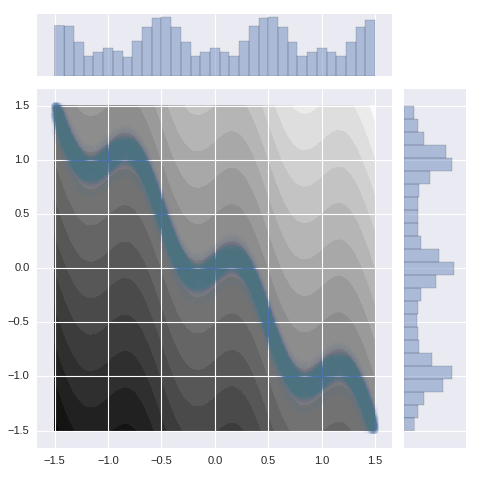

In [93]:
import seaborn as sns
sh = sns.jointplot(x=xs_, y=ys_, stat_func=None, s=40, alpha=0.02, edgecolors="none")
sh.fig.get_axes()[0].contourf(X1, X2, myfunc(X1, X2), cmap=plt.cm.gray, levels=levels, zorder=0) 


<IPython.core.display.Javascript object>


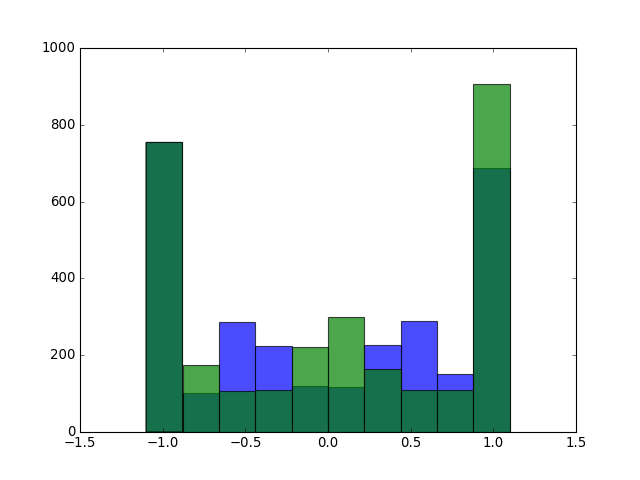

(array([ 754.,  175.,  107.,  110.,  221.,  300.,  165.,  109.,  110.,  907.]),
 array([ -1.10000000e+00,  -8.80000000e-01,  -6.60000000e-01,
         -4.40000000e-01,  -2.20000000e-01,  -2.22044605e-16,
          2.20000000e-01,   4.40000000e-01,   6.60000000e-01,
          8.80000000e-01,   1.10000000e+00]),
 <a list of 10 Patch objects>)

In [38]:
plt.figure()
plt.hist(xs_, alpha=0.7)
plt.hist(ys_, alpha=0.7)

In [64]:
likelihood = tm.Merge(pm.GaussianNoise(y, init_var=0.001), func, ignore_references={'parameters', 'parameters_positive'})
likelihood

Merge17 { 'inputs': [TensorConstant{(2,) of 0.5}], 'outputs': GaussianNoise3.outputs}

In [65]:
sampler = likelihood.function()
data = np.array([sampler([0.5, 0.5]) for n in range(5000)])

<IPython.core.display.Javascript object>


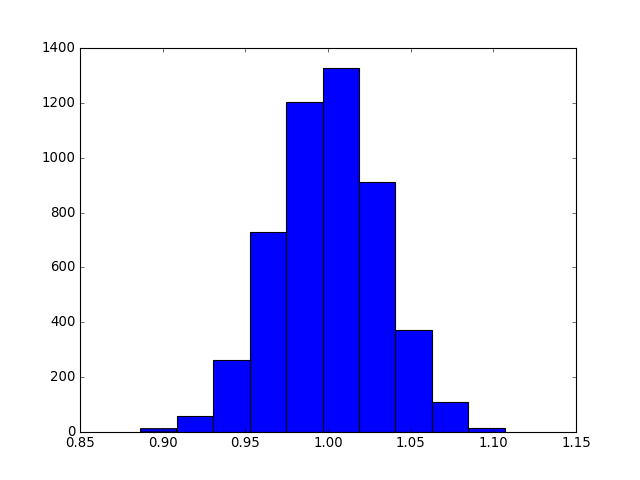

(array([   12.,    60.,   262.,   729.,  1202.,  1326.,   910.,   373.,
          110.,    16.]),
 array([ 0.88662594,  0.90865379,  0.93068163,  0.95270947,  0.97473732,
         0.99676516,  1.01879301,  1.04082085,  1.06284869,  1.08487654,
         1.10690438]),
 <a list of 10 Patch objects>)

In [66]:
plt.figure()
plt.hist(data)

In [67]:
def center_isoline(a):
    @np.vectorize
    def x2(x1):
        return a - x1 - 3/10*np.sin(2*np.pi*x1)
    return x2

<IPython.core.display.Javascript object>


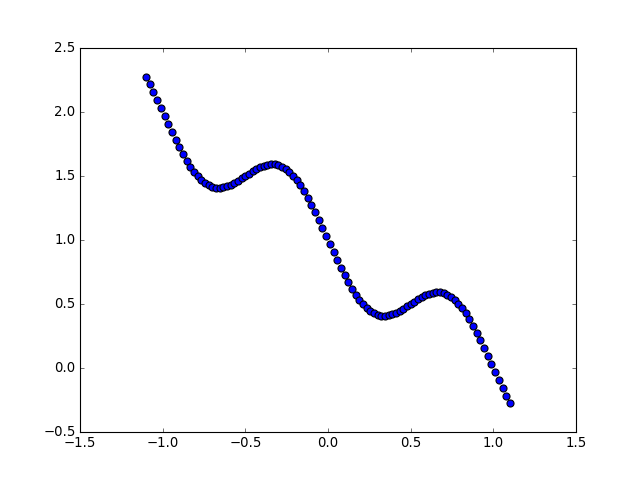

In [68]:
plt.figure()
num_x2 = center_isoline(1)(num_x)
plt.scatter(num_x, num_x2, s=40)

In [69]:
x = tm.as_tensor_variable([0.5, 0.5]) #T.vector()
y = (0.3 * T.sin(2*np.pi*(x[0]- 0.5)) + np.exp(-x[0]**2)
   + np.exp(-x[1]**2))
#+ np.exp(-x[1]**2))
func = tm.Model(inputs=[x], outputs=y, name="sin")
f = func.function()

In [70]:
@np.vectorize
def myfunc(a,b):
    return f([a,b])

<IPython.core.display.Javascript object>


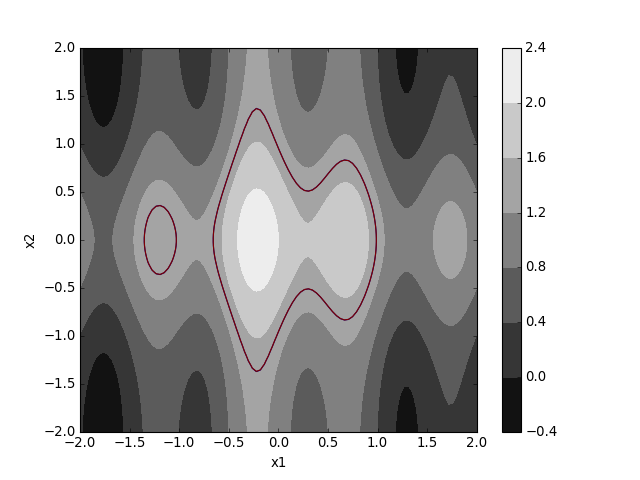

In [71]:
plt.figure()
# num_x = np.linspace(-0, 1, 100)
num_x = np.linspace(-1.1, 1.1, 100)
num_x = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(num_x, num_x)

# levels = np.linspace(-2.4, 2.4, 20)
h = plt.contourf(X1, X2, myfunc(X1, X2), cmap=plt.cm.gray)#, levels=levels)
l=1.4
h2 = plt.contour(X1, X2, myfunc(X1, X2), cmap=plt.cm.jet, levels=[l, l+0.001])
plt.xlabel("x1")
plt.ylabel("x2")

plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(h)